# Прикладной анализ временных рядов

Выполнил: студент AI Talent Hub ITMO \
ФИО: Щетинников К. \
Группа: M4254

## Формулировка задания

Построить модель прогнозирования спроса (продаж) на товары в магазине `STORE_2` офлаин-ритейлера в США. Всего в магазине 15 артикулов (товаров). Прогнозировать продажи нужно на неделю, на месяц и на квартал. В качестве дополнительной информации вам переданы данные о цене товара (меняются раз в неделю, а также о праздниках в США).

### Задание 1. 
Реализовать класс, который умеет: 

1) предобрабатывать исходные данные в удобный формат; 

2) обучаться для задачи прогнозирования; 

3) оценивать качество своих прогнозов;

4) сохранять модели и подгружать их; 

5) Прогнозировать продажи на неделю, на месяц и на квартал.

Должна быть рабочая программа, которая делает инференс (прогнозирование на произвольном тестовом датасете (аналогично тому, который есть у вас)).


### Задание 2. 
Подготовить отчёт о решении данной задачи в виде jupyter ноутбука. В отчёте, в частности, вы должны ответить на следующие вопросы:

1) Какие методы предобработки данных вы использовали?

2) Какие модели пробовали? Почему пробовали именно их?

3) Как вы проверяете качество модели? На каких данных? Какие метрики используюте? Чем обусловлен выбор именно этих метрик?

4) Какое итоговое качество модели на тестовом датасете?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from scipy.fft import fft, ifft, fftfreq

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels. tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

import warnings
warnings.filterwarnings('ignore')

sns.set_theme()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

e:\Files\3. Studing\Универ\ИТМО\2_семестр\Прикладной_анализ_временных_рядов\Лабораторная_работа\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# визуализация ряда, АКФ и ЧАКФ
def plot_acf_pacf(series, item_id, acf_lags=100, pacf_lags=30):
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))

    columns = [column for column in series.columns if column == 'date' or column == 'cnt' or column == 'resid']

    axes[0].plot(series[columns[0]], series[columns[1]])
    axes[0].set_title(f'Time series {item_id}')

    plot_acf(series[columns[1]], lags=acf_lags, ax=axes[1])
    axes[1].set_title('Autocorrelation Function (ACF)')

    plot_pacf(series[columns[1]], lags=pacf_lags, ax=axes[2])
    axes[2].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

# проверки на стационарность ряда
def test_trend(row):
    kpsstest = kpss(row, regression="c", nlags="auto")
    dftest = adfuller(row, autolag="AIC")

    nonstationary_kpss =  kpsstest[1] < 0.05
    nonstationary_df = dftest[1] > 0.05
    
    return nonstationary_kpss | nonstationary_df,  kpsstest[1], dftest[1]


def adf_test(series):
    stat, p_value, _, _, _, _ = adfuller(series, autolag='AIC')
    if p_value < 0.05:
        return True
    else:
        return False

def kpss_test(series):
    stat, p_value, _, _ = kpss(series, regression='c', nlags="auto")
    if p_value < 0.05:
        return False
    else:
        return True
    

# метрики качества прогноза
def metrics_report(y_true, y_pred):
    y_true_mean = y_true.mean().values * np.ones(shape=(len(y_true),))

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    mae_zero = mean_absolute_error(y_true_mean, y_pred)
    
    resport = pd.DataFrame([mse, r2, mae, mae_zero],
                            index=['mse', 'r2', 'mae', 'mae_zero'])

    return resport


# прогнозирование ряда с помощью преобразования Фурье
def fourierExtrapolation(x, n_predict, n_harm = 20, inner_freq = 1.0):
    """
    Функция для экстраполяции рядов Фурье. По вр х делает предикт на n_predict шагов
    с помощью топ n_harm гармоник по амплитуде.
    Возвращает исходный ряд + экстраполяцию на n_predict шагов
    
    https://gist.github.com/tartakynov/83f3cd8f44208a1856ce
    """
    n = x.size
    t = np.arange(0, n)

    x_freqdom = fft(x, axis=0)  # x in frequency domain
    f = fftfreq(n, inner_freq)  # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t * inner_freq  + phase)

    return restored_sig

## Данные

### 1. Чтение данных

In [3]:
df = pd.read_csv('./data/full_data.csv')
df['date'] = pd.to_datetime(df['date'])

# рассмотрим определенный артикул
art_681 = 'STORE_2_681'
df_681 = df[df['item_id'] == art_681]
df_681.head()

,date,wm_yr_wk,weekday,wday,month,year,date_id,CASHBACK_STORE_2,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend,item_id,store_id,cnt,sell_price
3,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,0,0,1,STORE_2_681,STORE_2,14,1.250
18,2011-01-30,11101,Sunday,2,1,2011,2,0,0,0,0,0,1,STORE_2_681,STORE_2,10,1.250
32,2011-01-31,11101,Monday,3,1,2011,3,0,0,0,0,0,0,STORE_2_681,STORE_2,9,1.250
48,2011-02-01,11101,Tuesday,4,2,2011,4,1,0,0,0,0,0,STORE_2_681,STORE_2,5,1.250
63,2011-02-02,11101,Wednesday,5,2,2011,5,1,0,0,0,0,0,STORE_2_681,STORE_2,6,1.250


### 2. Визуализация данных

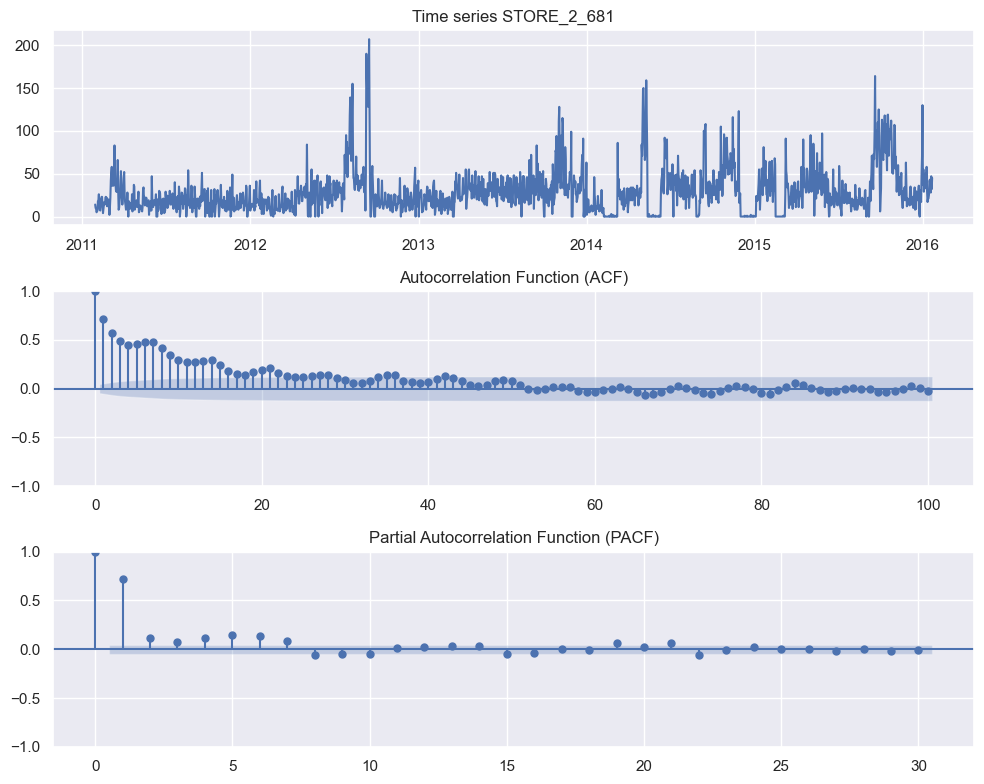

In [4]:
plot_acf_pacf(df_681, art_681, acf_lags=100, pacf_lags=30)

In [20]:
# тренеровочная и тестовая выборки
num_steps = 90
data = df_681[['date', 'cnt']].set_index('date')
data_test = data[-num_steps:]
data_train = data[:-num_steps]

## SARIMA

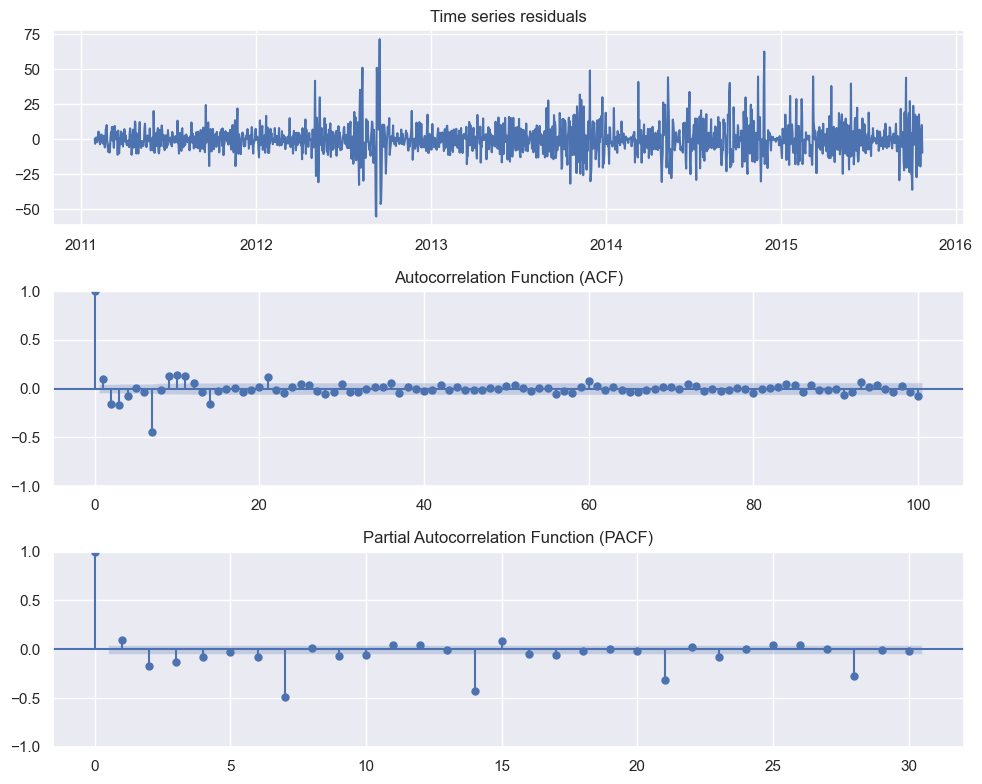

(False, 0.1, 5.872074749861962e-23)


In [6]:
# обучение модели STL
stl = STL(data_train, period=7)
result = stl.fit()

# графики остатков
plot_acf_pacf(result.resid.to_frame().reset_index(), 'residuals', acf_lags=100, pacf_lags=30)

## проверка на стационарность
print(test_trend(result.resid))

критерии показали, что ряд остатков стационарный

#### Подбор параметров

In [7]:
print('DF:', adf_test(data_train))
print('KPSS:', kpss_test(data_train))

DF: True
KPSS: False


При одновременном применении критериев KPSS и ADF могут получиться следующие результаты: 
    
* Вариант 1: Оба теста говорят, что ряд нестационарный – значит, ряд действительно нестационарный

* Вариант 2: Оба теста говорят, что ряд стационарный – ряд стационарный

* Вариант 3: KPSS говорит, что ряд стационарный, а ADF говорит, что ряд нестационарный – значит, у вр существует детерминированный тренд, который необходимо убрать, чтобы получить стационарный вр

* Вариант 4: KPSS говорит, что ряд нестационарный, а ADF - что ряд стационарный – значит, у вр существует стохастический тренд, который необходимо убрать, чтобы получить стационарный вр


У ряда есть стохастический тренд

In [8]:
# горизонт прогнозирования
fh = ForecastingHorizon(data_test.index, is_relative=False)

# обучение модели
model = AutoARIMA(sp=7, seasonal=True, max_p=2, max_q=2, stationary=False)
model.fit(data_train)

y_pred = model.predict(data.index)
model.get_fitted_params()

AutoARIMA(max_p=2, max_q=2, sp=7)

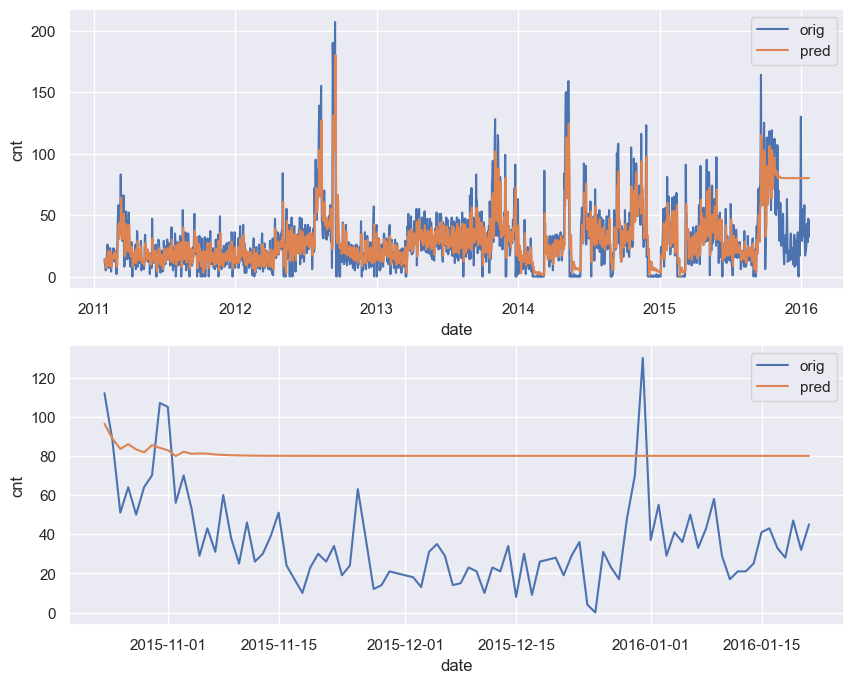

In [21]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(data, label='orig')
plt.plot(y_pred, label='pred')
plt.xlabel('date')
plt.ylabel('cnt');

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data_test, label='test')
plt.plot(y_pred[-num_steps:], label='pred')
plt.xlabel('date')
plt.ylabel('cnt');

plt.legend()

In [22]:
# горизонт прогнозирования
fh = ForecastingHorizon(data_test.index, is_relative=False)

# обучение модели
model = AutoARIMA(sp=7, seasonal=True, max_p=2, max_q=2, stationary=True)
model.fit(data_train)

y_pred = model.predict(data.index)
model.get_fitted_params()

{'intercept': 0.10636024371691513,
 'ar.L1': 0.8953099004646817,
 'ma.L1': -0.3327320474718581,
 'ma.L2': -0.15325285534867789,
 'ar.S.L7': 0.9969063578108927,
 'ar.S.L14': -0.04026607915555717,
 'ma.S.L7': -0.9049409063279882,
 'sigma2': 271.1975127538745,
 'order': (1, 0, 2),
 'seasonal_order': (2, 0, 1, 7),
 'aic': 14615.791557168512,
 'aicc': 14615.875278098743,
 'bic': 14659.433945053977,
 'hqic': 14631.934356940292}

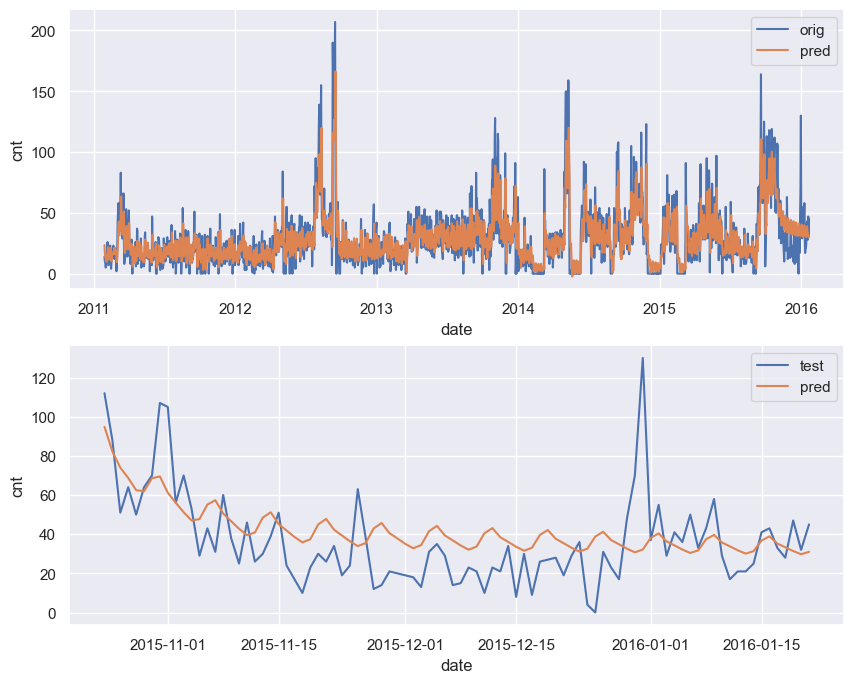

In [23]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(data, label='orig')
plt.plot(y_pred, label='pred')
plt.xlabel('date')
plt.ylabel('cnt');

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data_test, label='test')
plt.plot(y_pred[-num_steps:], label='pred')
plt.xlabel('date')
plt.ylabel('cnt');

plt.legend()

In [25]:
# Оценка качества модели
arima_rep = metrics_report(data_test, y_pred[-num_steps:])
arima_rep.columns = ['SARIMA']
arima_rep

,SARIMA
mse,402.861
r2,0.275
mae,15.355
mae_zero,8.007


## Fourier

In [59]:
# выделяем из ряда полиномный тренд
forecaster = PolynomialTrendForecaster(degree=3)
forecaster.fit(data_train)

data_train_detrend = Detrender(forecaster).fit_transform(data_train) 
trend_pred = forecaster.predict(fh=np.arange(1, num_steps + 1))
trend = pd.concat([data_train - data_train_detrend, trend_pred])

In [60]:
# проверка на стационарность
print('DF:', adf_test(data_train_detrend))
print('KPSS:', kpss_test(data_train_detrend))

DF: True
KPSS: True


In [63]:
# n_harm = 20
pred_20 = fourierExtrapolation(data_train_detrend, n_predict=num_steps, n_harm=20, inner_freq=1.0)
pred_20 = pd.DataFrame(pred_20, index=data.index)
pred_20.columns = trend_pred.columns
pred_20 = pred_20 + trend

# n_harm = 250
pred_250 = fourierExtrapolation(data_train_detrend, n_predict=num_steps, n_harm=250, inner_freq=1.0)
pred_250 = pd.DataFrame(pred_250, index=data.index)
pred_250.columns = trend_pred.columns
pred_250 = pred_250 + trend

# n_harm = 500
pred_500 = fourierExtrapolation(data_train_detrend, n_predict=num_steps, n_harm=500, inner_freq=1.0)
pred_500 = pd.DataFrame(pred_500, index=data.index)
pred_500.columns = trend_pred.columns
pred_500 = pred_500 + trend

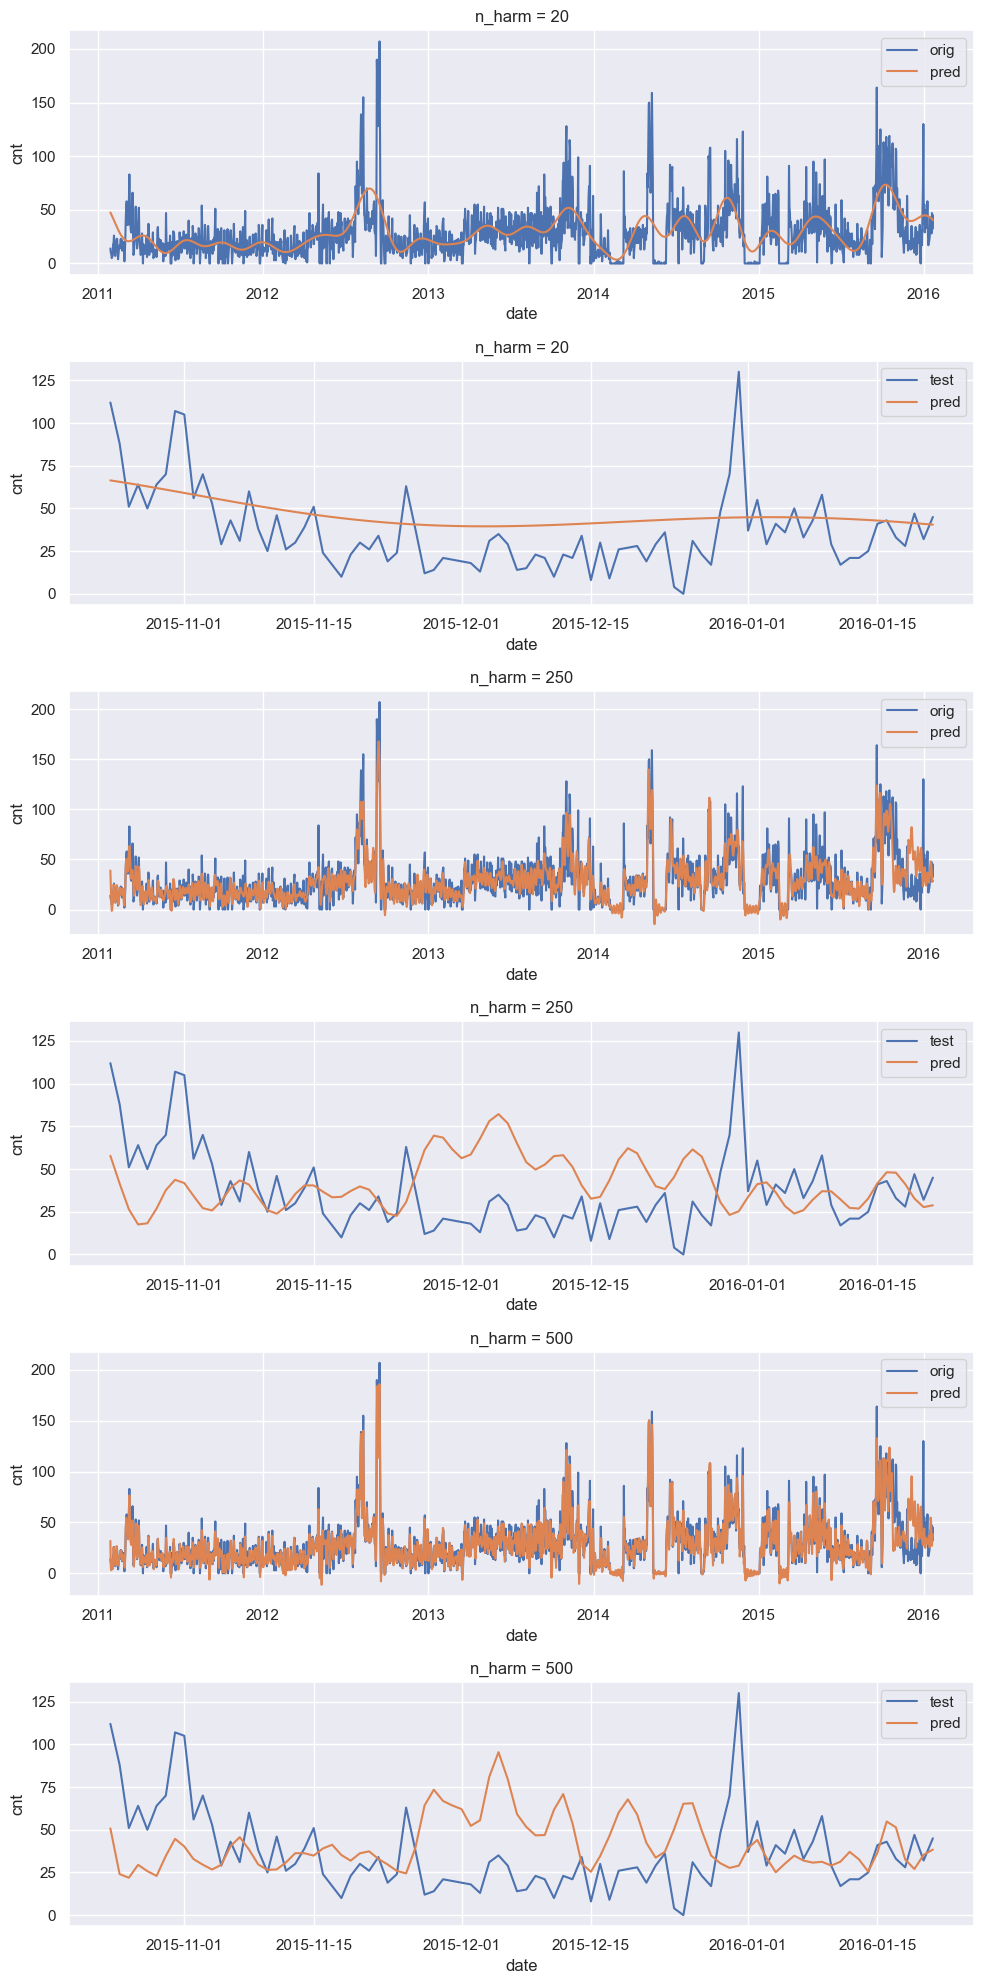

In [65]:
# Визуализация результатов
plt.figure(figsize=(10, 20))

plt.subplot(6, 1, 1)
plt.plot(data, label='orig')
plt.plot(pred_20, label='pred')
plt.title('n_harm = 20')
plt.xlabel('date')
plt.ylabel('cnt')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(data_test, label='test')
plt.plot(pred_20[-num_steps:], label='pred')
plt.title('n_harm = 20')
plt.xlabel('date')
plt.ylabel('cnt')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(data, label='orig')
plt.plot(pred_250, label='pred')
plt.title('n_harm = 250')
plt.xlabel('date')
plt.ylabel('cnt')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(data_test, label='test')
plt.plot(pred_250[-num_steps:], label='pred')
plt.title('n_harm = 250')
plt.xlabel('date')
plt.ylabel('cnt')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(data, label='orig')
plt.plot(pred_500, label='pred')
plt.title('n_harm = 500')
plt.xlabel('date')
plt.ylabel('cnt')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(data_test, label='test')
plt.plot(pred_500[-num_steps:], label='pred')
plt.title('n_harm = 500')
plt.xlabel('date')
plt.ylabel('cnt')
plt.legend()

plt.tight_layout()
plt.show()

In [66]:
fourier_rep = metrics_report(data_test, pred_500[-num_steps:])
fourier_rep.columns = ['Fourier']
fourier_rep

,Fourier
mse,1041.728
r2,-0.875
mae,25.022
mae_zero,11.430


## Prophet

In [67]:
# праздники
calendar_data = pd.read_csv('./data/shop_sales_dates.csv')
calendar_data['date'] = pd.to_datetime(calendar_data['date'])
calendar_data['event'] = calendar_data['event_name_1'].combine_first(calendar_data['event_name_2'])

holidays_data = calendar_data.dropna(subset=['event'])
holidays = holidays_data[['date', 'event']]
holidays = holidays.rename(columns={'date': 'ds', 'event': 'holiday'})
holidays

,ds,holiday
8,2011-02-06,SuperBowl
16,2011-02-14,ValentinesDay
23,2011-02-21,PresidentsDay
39,2011-03-09,LentStart
46,2011-03-16,LentWeek2
...,...,...
1780,2015-12-14,Chanukah End
1791,2015-12-25,Christmas
1798,2016-01-01,NewYear
1804,2016-01-07,OrthodoxChristmas


In [68]:
# все данные
df_prophet = df_681.reset_index(drop=True).\
                    rename(columns={'date': 'ds', 
                                    'cnt': 'y'})

# тренеровочная и тестовая выборки
data_train = df_prophet.iloc[:-num_steps]
data_test = df_prophet.iloc[-num_steps:]
data_train.head()

,ds,wm_yr_wk,weekday,wday,month,year,date_id,CASHBACK_STORE_2,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend,item_id,store_id,y,sell_price
0,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,0,0,1,STORE_2_681,STORE_2,14,1.250
1,2011-01-30,11101,Sunday,2,1,2011,2,0,0,0,0,0,1,STORE_2_681,STORE_2,10,1.250
2,2011-01-31,11101,Monday,3,1,2011,3,0,0,0,0,0,0,STORE_2_681,STORE_2,9,1.250
3,2011-02-01,11101,Tuesday,4,2,2011,4,1,0,0,0,0,0,STORE_2_681,STORE_2,5,1.250
4,2011-02-02,11101,Wednesday,5,2,2011,5,1,0,0,0,0,0,STORE_2_681,STORE_2,6,1.250


In [69]:
# модель
model = Prophet(holidays=holidays)

model.add_regressor('CASHBACK_STORE_2')
model.add_regressor('type_Cultural')
model.add_regressor('type_Sporting')
model.add_regressor('type_Religious')
model.add_regressor('type_National')

model.fit(data_train)

future = model.make_future_dataframe(periods=num_steps)

02:11:19 - cmdstanpy - INFO - Chain [1] start processing
02:11:20 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
forecast = model.predict(df_prophet)
test_forecast = forecast.iloc[-num_steps:]
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,CASHBACK_STORE_2,CASHBACK_STORE_2_lower,CASHBACK_STORE_2_upper,Chanukah End,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1729,2015-10-24,36.131,32.712,88.112,36.131,36.131,0.000,0.000,0.000,0.000,...,9.425,9.425,9.425,15.690,15.690,15.690,0.000,0.000,0.000,61.246
1730,2015-10-25,36.144,28.049,82.726,36.144,36.144,0.000,0.000,0.000,0.000,...,2.422,2.422,2.422,16.658,16.658,16.658,0.000,0.000,0.000,55.224
1731,2015-10-26,36.156,21.491,76.986,36.156,36.156,0.000,0.000,0.000,0.000,...,-4.128,-4.128,-4.128,17.505,17.505,17.505,0.000,0.000,0.000,49.534
1732,2015-10-27,36.169,21.519,75.772,36.169,36.169,0.000,0.000,0.000,0.000,...,-4.907,-4.907,-4.907,18.217,18.217,18.217,0.000,0.000,0.000,49.478
1733,2015-10-28,36.181,23.461,76.406,36.181,36.181,0.000,0.000,0.000,0.000,...,-5.343,-5.343,-5.343,18.783,18.783,18.783,0.000,0.000,0.000,49.622


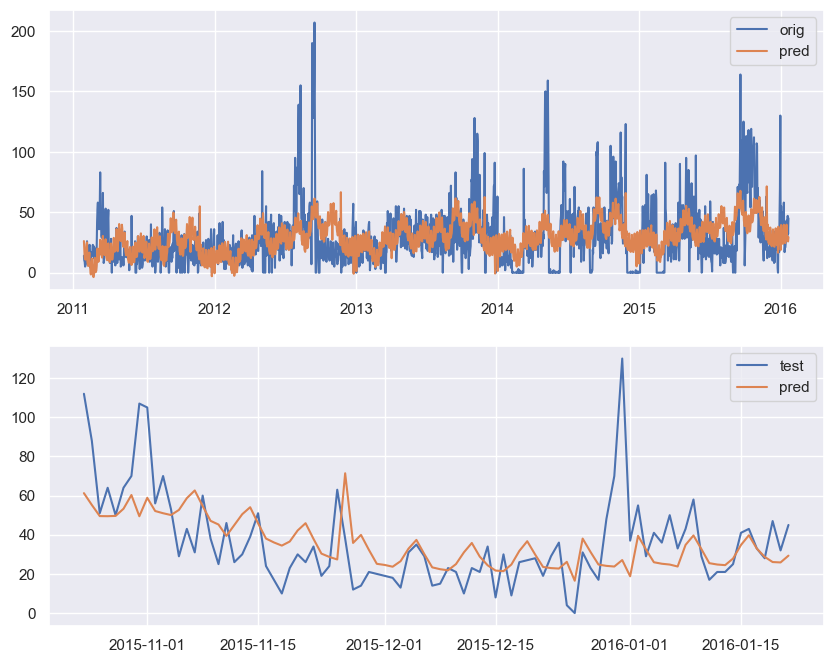

In [71]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(df_prophet.set_index('ds').y, label='orig')
plt.plot(forecast.set_index('ds').yhat, label='pred')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data_test.set_index('ds').y, label='test')
plt.plot(test_forecast.set_index('ds').yhat, label='pred')

plt.legend()

In [72]:
prophet_rep = metrics_report(data_test.set_index('ds')[['y']], test_forecast.set_index('ds')[['yhat']])
prophet_rep.columns = ['Prophet']
prophet_rep

,Prophet
mse,426.335
r2,0.233
mae,14.409
mae_zero,10.272


## Результаты

In [73]:
report = pd.concat([arima_rep, fourier_rep, prophet_rep], axis=1)
report

,SARIMA,Fourier,Prophet
mse,402.861,1041.728,426.335
r2,0.275,-0.875,0.233
mae,15.355,25.022,14.409
mae_zero,8.007,11.430,10.272
